In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [124]:
df=pd.read_csv(r"dataset/twitter_training.csv")
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [125]:
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet'})
df = df.rename(columns={'Positive': 'sentiment'})
df = df.rename(columns={'Borderlands': 'entity'})
df = df.rename(columns={'2401': 'ID'})

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   entity     74681 non-null  object
 2   sentiment  74681 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [127]:
df.isnull().sum()

ID             0
entity         0
sentiment      0
Tweet        686
dtype: int64

In [128]:
df.dropna(axis=0,inplace=True)

In [129]:
df.isnull().sum()

ID           0
entity       0
sentiment    0
Tweet        0
dtype: int64

In [130]:
df.duplicated().sum()

np.int64(2340)

In [131]:
df = df.drop_duplicates()


## Preprocessing on Text

In [132]:
import emoji
import contractions
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = contractions.fix(text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    negations = {"not", "no", "nor", "never"}
    stop_words = set(stopwords.words('english')) - negations
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


df['processed_text'] = df['Tweet'].apply(preprocess_text)
df[['Tweet', 'processed_text']].head()

,Tweet,processed_text
0,I am coming to the borders and I will kill you...,coming border kill
1,im getting on borderlands and i will kill you ...,getting borderland kill
2,im coming on borderlands and i will murder you...,coming borderland murder
3,im getting on borderlands 2 and i will murder ...,getting borderland 2 murder
4,im getting into borderlands and i can murder y...,getting borderland murder


In [133]:
df["hashtags"] = df["Tweet"].apply(lambda x: re.findall(r'#\w+', x))
df["mentions"] = df["Tweet"].apply(lambda x: re.findall(r'@\w+', x))

In [134]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
df['tokens'] = df['Tweet'].apply(lambda text: tokenizer.tokenize(text))

In [135]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RTX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RTX\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RTX\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RTX\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\RTX\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [136]:
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tweet(tweet):
    tokens = tokenizer.tokenize(tweet)
    pos_tokens = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tokens]
    return lemmas

df['lemmas'] = df['Tweet'].apply(lemmatize_tweet)

In [137]:
df['Clean_Text']=df['Tweet'].apply(lambda x: preprocess_text(x))
print('Text Preprocessing is done')

Text Preprocessing is done


In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    sublinear_tf=True,
)

tfidf_matrix = vectorizer.fit_transform(df['lemmas'].apply(lambda x: ' '.join(x)))


In [139]:
!pip install sentence-transformers


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

texts = df['lemmas'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    sublinear_tf=True
)


tfidf_matrix = vectorizer.fit_transform(texts)
tfidf_dense = tfidf_matrix.toarray()



In [141]:
print(tfidf_dense.shape)

(71655, 10000)


## Exploratory Data Analysis 

In [142]:
df['text_length'] = df['Clean_Text'].apply(lambda x: len(x.split()))
df['text_length'].describe()

count    71655.000000
mean        11.026041
std          8.132207
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max        198.000000
Name: text_length, dtype: float64

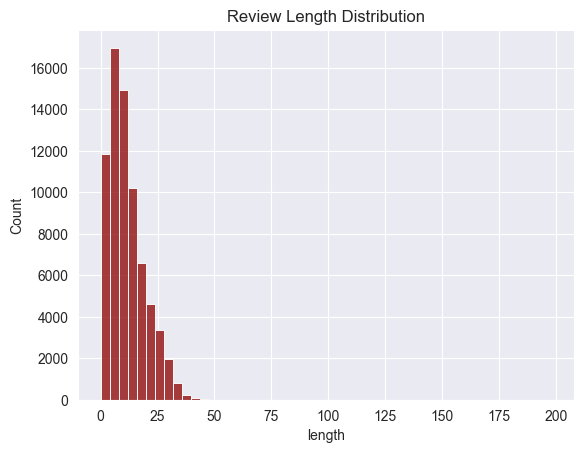

In [143]:
import warnings
warnings.filterwarnings("ignore")

df['length'] = df['Clean_Text'].apply(lambda x: len(x.split()))

sns.set_style('darkgrid')
sns.histplot(df['length'], bins=50, color='darkred')
plt.title("Review Length Distribution")
plt.show()

In [144]:
note = """
The provided dataset does not include a timestamp field.
Therefore, temporal sentiment trend analysis and anomaly detection
could not be performed because they require chronological data.
All other EDA components (sentiment distribution, word freq, n-grams,
mention/retweet network, geographic mapping) will be implemented.
"""
print(note)


The provided dataset does not include a timestamp field.
Therefore, temporal sentiment trend analysis and anomaly detection
could not be performed because they require chronological data.
All other EDA components (sentiment distribution, word freq, n-grams,
mention/retweet network, geographic mapping) will be implemented.



In [145]:
# Sentiment distribution
import matplotlib.pyplot as plt

sent_counts = df['sentiment'].value_counts()
print("Counts:\n", sent_counts)

Counts:
 sentiment
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64


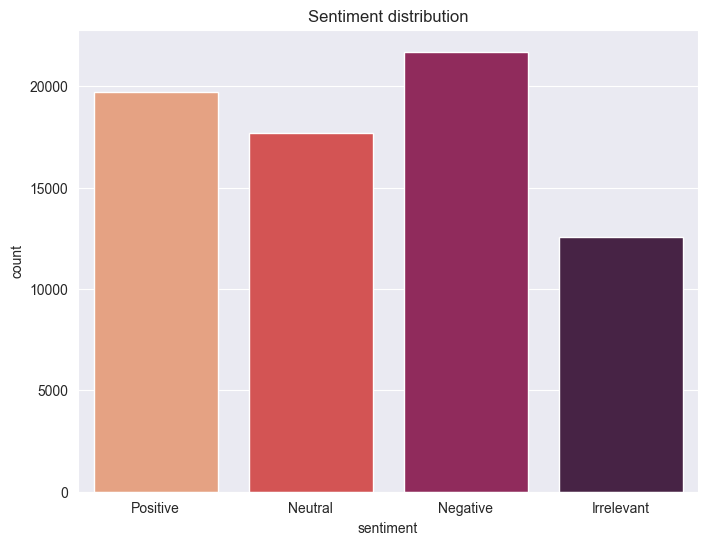

In [146]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='sentiment', palette='rocket_r')
plt.title('Sentiment distribution')
plt.show()

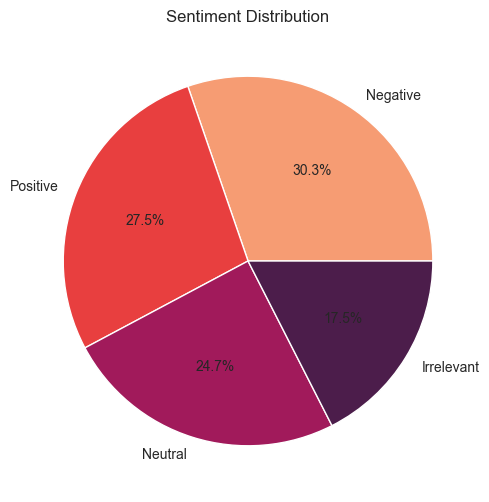

In [147]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('rocket_r', len(sentiment_counts)))
plt.title('Sentiment Distribution')
plt.show()

In [148]:
#  Word frequency per sentiment
from collections import Counter
import nltk

def top_n_words(texts, n=20):
    tokens = []
    for t in texts:
        tokens += nltk.word_tokenize(t)
    freq = Counter(tokens)
    return freq.most_common(n)

for s in df['sentiment'].unique():
    texts = df.loc[df['sentiment']==s, 'processed_text'].dropna().astype(str).tolist()
    print(f"\nTop words for sentiment = {s}:")
    print(top_n_words(texts, n=25))


Top words for sentiment = Positive:
[('not', 3152), ('game', 3056), ('love', 1736), ('good', 1551), ('like', 1334), ('really', 1275), ('2', 1256), ('new', 1180), ('time', 1103), ('best', 1087), ('play', 1080), ('one', 1075), ('great', 961), ('get', 959), ('3', 922), ('playing', 912), ('fun', 894), ('going', 875), ('wait', 783), ('look', 776), ('year', 738), ('thank', 726), ('day', 701), ('red', 697), ('see', 695)]

Top words for sentiment = Neutral:
[('not', 2951), ('johnson', 1793), ('game', 1605), ('2', 1318), ('amazon', 1106), ('_', 1078), ('get', 1000), ('like', 931), ('one', 870), ('new', 841), ('play', 833), ('google', 818), ('facebook', 812), ('u', 795), ('3', 764), ('time', 708), ('good', 685), ('people', 674), ('no', 673), ('microsoft', 672), ('dead', 670), ('video', 651), ('red', 647), ('see', 646), ('com', 640)]

Top words for sentiment = Negative:
[('not', 7021), ('game', 4471), ('get', 1815), ('like', 1609), ('no', 1526), ('shit', 1476), ('fix', 1320), ('play', 1233), ('f

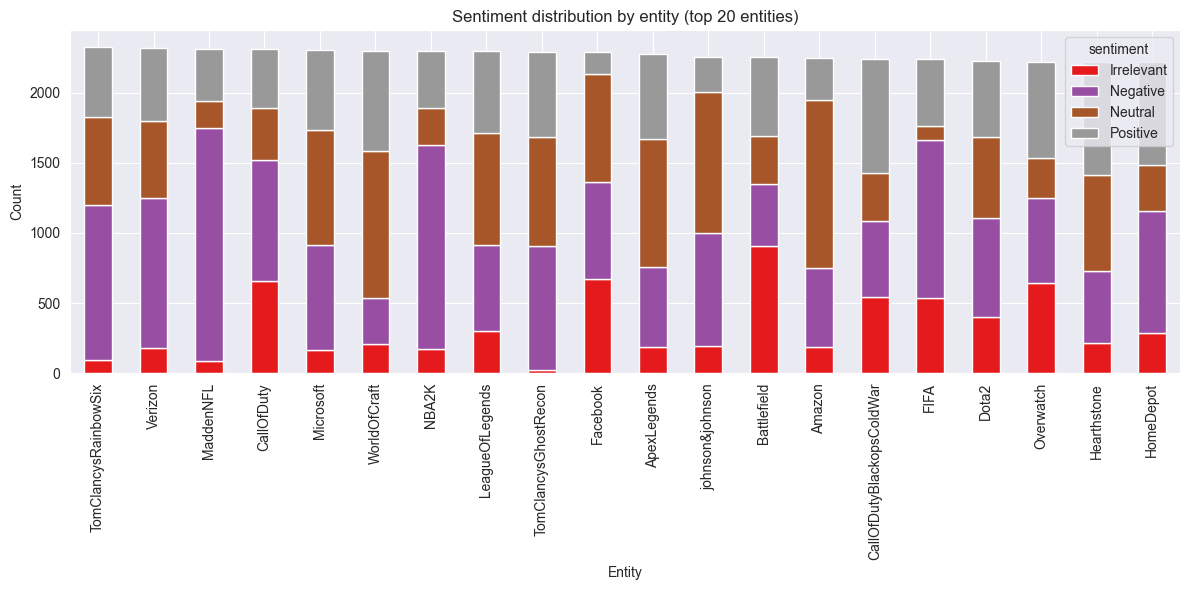

In [149]:
# Sentiment distribution by entity
import matplotlib.pyplot as plt

if 'entity' in df.columns:
    sent_by_entity = df.groupby('entity')['sentiment'].value_counts().unstack(fill_value=0)

    top_entities = sent_by_entity.sum(axis=1).sort_values(ascending=False).head(20).index
    top_sent_by_entity = sent_by_entity.loc[top_entities]

    top_sent_by_entity.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set1')
    plt.title("Sentiment distribution by entity (top 20 entities)")
    plt.xlabel("Entity")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'entity' column available in the dataset.")

In [150]:
#N-grams per sentiment
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, ngram_range=(1,1), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for s in df['sentiment'].unique():
    corpus = df.loc[df['sentiment']==s, 'processed_text'].dropna().astype(str).tolist()
    print(f"\nTop 15 bigrams for {s}:")
    print(top_ngrams(corpus, ngram_range=(2,2), n=15))
    print(f"\nTop 15 trigrams for {s}:")
    print(top_ngrams(corpus, ngram_range=(3,3), n=15))


Top 15 bigrams for Positive:
[('red dead', np.int64(581)), ('assassin creed', np.int64(551)), ('dead redemption', np.int64(485)), ('home depot', np.int64(326)), ('xbox series', np.int64(218)), ('rhandlerr rhandlerr', np.int64(200)), ('black ops', np.int64(200)), ('league legend', np.int64(181)), ('cold war', np.int64(178)), ('looking forward', np.int64(155)), ('johnson johnson', np.int64(143)), ('cyberpunk 2077', np.int64(129)), ('creed odyssey', np.int64(124)), ('world warcraft', np.int64(117)), ('ops cold', np.int64(111))]

Top 15 trigrams for Positive:
[('red dead redemption', np.int64(454)), ('rhandlerr rhandlerr rhandlerr', np.int64(110)), ('assassin creed odyssey', np.int64(106)), ('black ops cold', np.int64(102)), ('ops cold war', np.int64(99)), ('italy italy italy', np.int64(97)), ('pa pa pa', np.int64(90)), ('access health care', np.int64(72)), ('assassin creed valhalla', np.int64(58)), ('assassin creed game', np.int64(51)), ('new assassin creed', np.int64(45)), ('red dead re

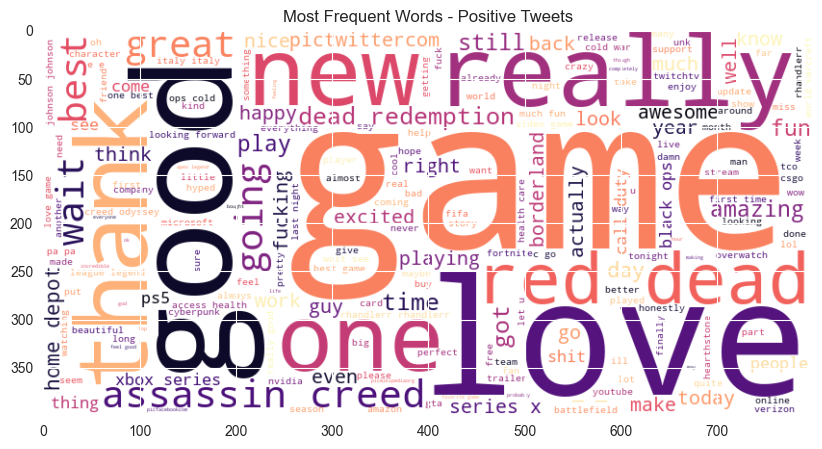

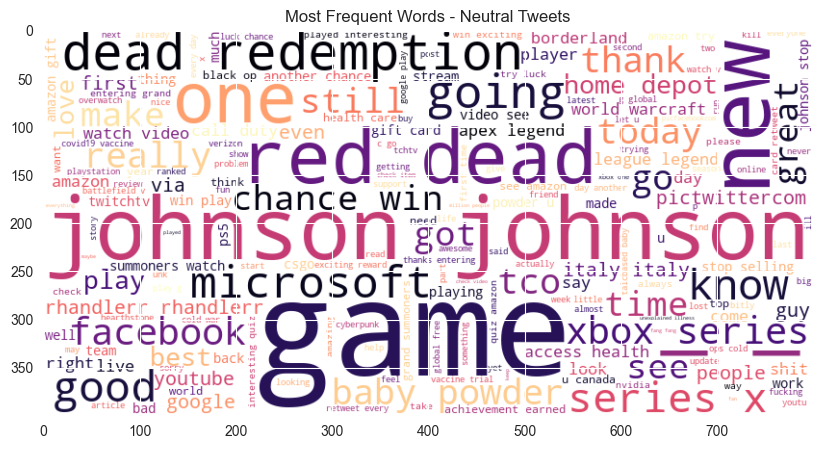

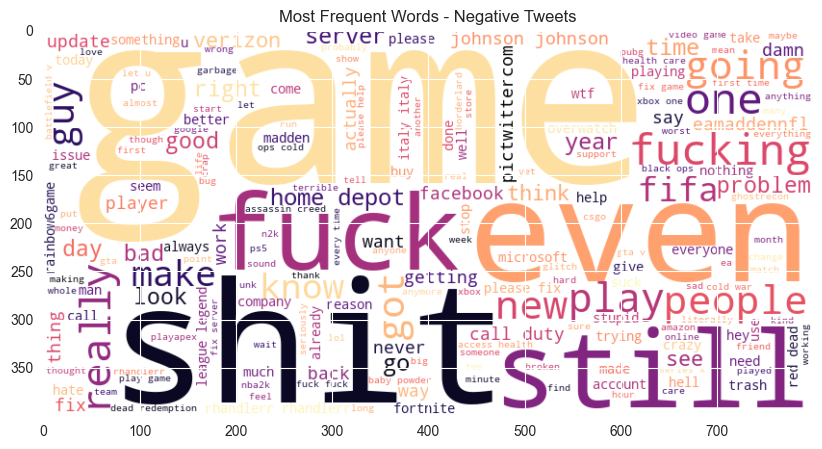

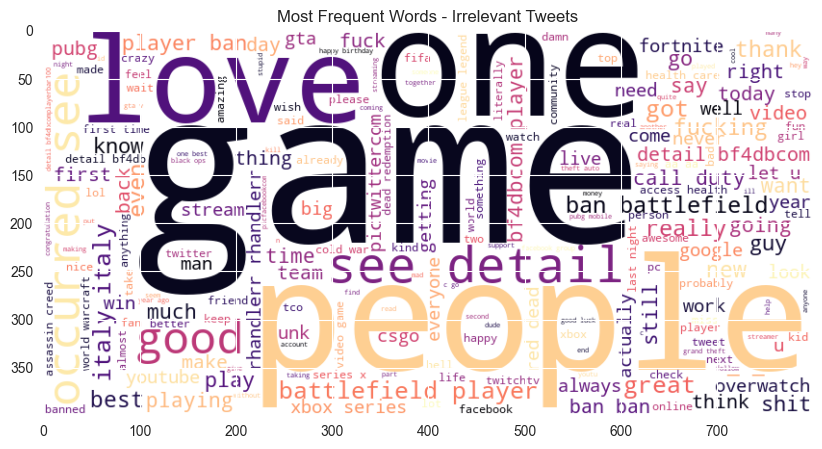

In [151]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment']==sentiment]['processed_text'].astype(str))
    
    wc = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Most Frequent Words - {sentiment.capitalize()} Tweets')
    plt.show()

In [152]:
import re
def extract_mentions(text):
    return re.findall(r'@(\w+)', text)
edges = []

for text in df['Tweet']:
    mentions = extract_mentions(text)
    if len(mentions) > 1:
        for i in range(len(mentions) - 1):
            edges.append((mentions[i], mentions[i+1]))

In [162]:
import networkx as nx

# -------------------------------
# Create an empty graph to store mention relationships
G = nx.Graph()
print("\n--- Graph object created ---\n")

# -------------------------------
# Add all mention-based edges to the graph
G.add_edges_from(edges)
print(f"--- {len(edges)} edges added to the graph ---\n")

# -------------------------------
# Extract all mentions from the 'Tweet' column and count how many times each username is mentioned
mention_counts = df['Tweet'].str.findall(r'@(\w+)').explode().value_counts()
print("--- Top 20 most frequently mentioned usernames ---")
print(mention_counts.head(20))
print("\n-------------------------------\n")

# -------------------------------
# Calculate degree centrality for each node in the graph (how connected each user is)
centrality = nx.degree_centrality(G)
print("--- Degree centrality calculated ---\n")

# Sort users by highest centrality to identify the mos
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("--- Top 10 users by centrality ---")
print(sorted_centrality[:10])
print("\n-------------------------------\n")



--- Graph object created ---

--- 6308 edges added to the graph ---

--- Top 20 most frequently mentioned usernames ---
Tweet
EAMaddenNFL        829
Rainbow6Game       731
NBA2K              705
GhostRecon         467
PlayApex           405
CallofDuty         338
Verizon            260
YouTube            221
Ubisoft            220
verizon            215
FortniteGame       194
PlayHearthstone    186
HomeDepot          173
Borderlands        171
UbisoftSupport     171
Ronnie2K           167
NBA2K_MyTEAM       152
nvidia             150
DOTA2              145
LeagueOfLegends    127
Name: count, dtype: int64

-------------------------------

--- Degree centrality calculated ---

--- Top 10 users by centrality ---
[('EAMaddenNFL', 0.03026634382566586), ('NBA2K', 0.019975786924939468), ('Verizon', 0.019975786924939468), ('PlayApex', 0.018159806295399518), ('Microsoft', 0.017554479418886198), ('CallofDuty', 0.01694915254237288), ('Rainbow6Game', 0.015738498789346248), ('GhostRecon', 0.014527

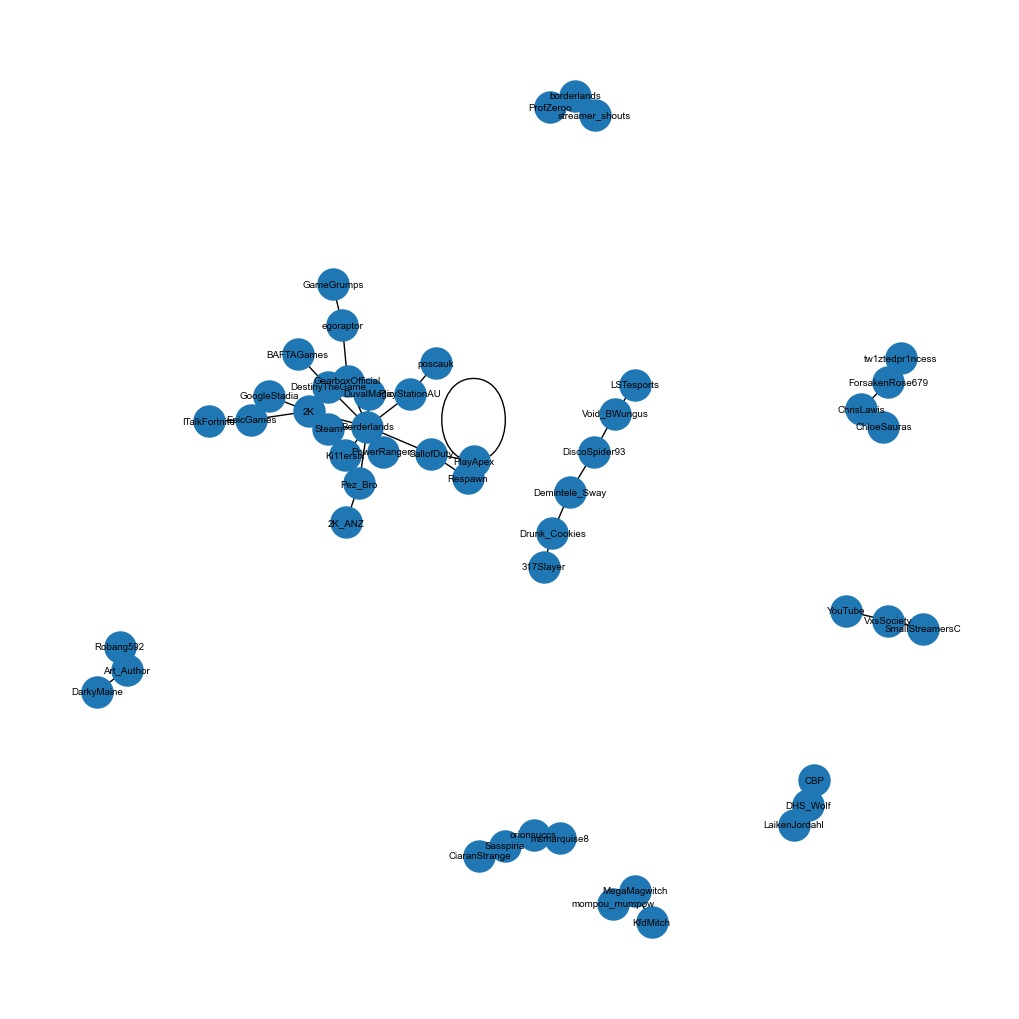

In [163]:
plt.figure(figsize=(10,10))

subgraph = G.subgraph(list(centrality.keys())[:50])

pos = nx.spring_layout(subgraph, seed=42)

nx.draw(subgraph, pos, with_labels=True, node_size=500 ,font_size=7)

plt.show()

In [155]:
print(" Temporal sentiment analysis and anomaly detection cannot be performed: dataset has no timestamp column.")

 Temporal sentiment analysis and anomaly detection cannot be performed: dataset has no timestamp column.


In [156]:
message = (
    "Geographic sentiment mapping was not performed because the dataset does not contain location data.\n"
    "The 'entity' column contains names of companies, games, and products rather than geographic locations.\n"
    "Therefore, geographic visualization is not applicable.\n"
    "Instead, sentiment analysis was visualized using bar charts and pie charts to show the distribution of sentiments across different entities."
)

print(message)

Geographic sentiment mapping was not performed because the dataset does not contain location data.
The 'entity' column contains names of companies, games, and products rather than geographic locations.
Therefore, geographic visualization is not applicable.
Instead, sentiment analysis was visualized using bar charts and pie charts to show the distribution of sentiments across different entities.


## Encoding & split

In [157]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df["sentiment"]=encoder.fit_transform(df['sentiment'])
df

,ID,entity,sentiment,Tweet,processed_text,hashtags,mentions,tokens,lemmas,Clean_Text,text_length,length
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming border kill,[],[],"[I, am, coming, to, the, borders, and, I, will...","[I, be, come, to, the, border, and, I, will, k...",coming border kill,3,3
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,getting borderland kill,[],[],"[im, getting, on, borderlands, and, i, will, k...","[im, get, on, borderland, and, i, will, kill, ...",getting borderland kill,3,3
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,coming borderland murder,[],[],"[im, coming, on, borderlands, and, i, will, mu...","[im, come, on, borderland, and, i, will, murde...",coming borderland murder,3,3
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,getting borderland 2 murder,[],[],"[im, getting, on, borderlands, 2, and, i, will...","[im, get, on, borderland, 2, and, i, will, mur...",getting borderland 2 murder,4,4
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,getting borderland murder,[],[],"[im, getting, into, borderlands, and, i, can, ...","[im, get, into, borderland, and, i, can, murde...",getting borderland murder,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
74676,9200,Nvidia,3,Just realized that the Windows partition of my...,realized window partition mac like 6 year behi...,[],[],"[Just, realized, that, the, Windows, partition...","[Just, realize, that, the, Windows, partition,...",realized window partition mac like 6 year behi...,14,14
74677,9200,Nvidia,3,Just realized that my Mac window partition is ...,realized mac window partition 6 year behind nv...,[],[],"[Just, realized, that, my, Mac, window, partit...","[Just, realize, that, my, Mac, window, partiti...",realized mac window partition 6 year behind nv...,13,13
74678,9200,Nvidia,3,Just realized the windows partition of my Mac ...,realized window partition mac 6 year behind nv...,[],[],"[Just, realized, the, windows, partition, of, ...","[Just, realize, the, window, partition, of, my...",realized window partition mac 6 year behind nv...,13,13
74679,9200,Nvidia,3,Just realized between the windows partition of...,realized window partition mac like 6 year behi...,[],[],"[Just, realized, between, the, windows, partit...","[Just, realize, between, the, window, partitio...",realized window partition mac like 6 year behi...,16,16


In [158]:
df['sentiment'].value_counts()

sentiment
1    21698
3    19712
2    17708
0    12537
Name: count, dtype: int64

In [159]:
x=df["processed_text"]
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(x,y ,test_size=0.2, random_state=42, stratify=y)

In [160]:
print(X_train.shape)
print(X_test.shape)

(57324,)
(14331,)
